In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

df = pd.read_csv('./datasets/train.csv')
print(df.head(5))

   Id  Popularity                                       Page content
0   0          -1  <html><head><div class="article-info"> <span c...
1   1           1  <html><head><div class="article-info"><span cl...
2   2           1  <html><head><div class="article-info"><span cl...
3   3          -1  <html><head><div class="article-info"><span cl...
4   4          -1  <html><head><div class="article-info"><span cl...


### Read and Split Data

In [2]:
print("Label:\n", df.loc[0, 'Popularity'])
print("Content:\n",df.loc[0,'Page content'])

Label:
 -1
Content:
 <html><head><div class="article-info"> <span class="byline basic">Clara Moskowitz</span> for <a href="/publishers/space-com/">Space.com</a> <time datetime="Wed, 19 Jun 2013 15:04:30 +0000">2013-06-19 15:04:30 UTC</time> </div></head><body><h1 class="title">NASA's Grand Challenge: Stop Asteroids From Destroying Earth</h1><figure class="article-image"><img class="microcontent" data-fragment="lead-image" data-image="http://i.amz.mshcdn.com/I7b9cUsPSztew7r1WT6_iBLjflo=/950x534/2013%2F06%2F19%2Ffe%2FDactyl.44419.jpg" data-micro="1" data-url="http://mashable.com/2013/06/19/nasa-grand-challenge-asteroid/" src="http://i.amz.mshcdn.com/I7b9cUsPSztew7r1WT6_iBLjflo=/950x534/2013%2F06%2F19%2Ffe%2FDactyl.44419.jpg"/></figure><article data-channel="world"><section class="article-content"> <p>There may be killer asteroids headed for Earth, and NASA has decided to do something about it. The space agency announced a new "Grand Challenge" on June 18 to find all dangerous space rocks

In [3]:
X = df.loc[:, 'Page content'].to_numpy()
y = df.loc[:,'Popularity'].to_numpy()
print(X.shape, y.shape)
print(X[:5])

(27643,) (27643,)
['<html><head><div class="article-info"> <span class="byline basic">Clara Moskowitz</span> for <a href="/publishers/space-com/">Space.com</a> <time datetime="Wed, 19 Jun 2013 15:04:30 +0000">2013-06-19 15:04:30 UTC</time> </div></head><body><h1 class="title">NASA\'s Grand Challenge: Stop Asteroids From Destroying Earth</h1><figure class="article-image"><img class="microcontent" data-fragment="lead-image" data-image="http://i.amz.mshcdn.com/I7b9cUsPSztew7r1WT6_iBLjflo=/950x534/2013%2F06%2F19%2Ffe%2FDactyl.44419.jpg" data-micro="1" data-url="http://mashable.com/2013/06/19/nasa-grand-challenge-asteroid/" src="http://i.amz.mshcdn.com/I7b9cUsPSztew7r1WT6_iBLjflo=/950x534/2013%2F06%2F19%2Ffe%2FDactyl.44419.jpg"/></figure><article data-channel="world"><section class="article-content"> <p>There may be killer asteroids headed for Earth, and NASA has decided to do something about it. The space agency announced a new "Grand Challenge" on June 18 to find all dangerous space rocks

### Feature Engineering

In [4]:
import os

POSITIVE_WORDS = os.path.join(os.getcwd(), 'datasets', 'positive-words.txt')
NEGATIVE_WORDS = os.path.join(os.getcwd(), 'datasets', 'negative-words.txt')
pos_words = []
neg_words = []


for line in open(POSITIVE_WORDS, 'r').readlines()[35:]:
    word = line.rstrip()
    pos_words.append(word)

for line in open(NEGATIVE_WORDS, 'r').readlines()[35:]:
    word = line.rstrip()
    neg_words.append(word)

In [5]:
print(len(pos_words))
print(len(neg_words))

2006
4783


In [9]:
import re
from bs4 import BeautifulSoup

def preprocessor(text):
    # remove HTML tags
    text = BeautifulSoup(text, 'html.parser').get_text()

    # regex for matching emoticons, keep emoticons, ex: :), :-P, :-D
    r = r'(?::|;|=|X)(?:-)?(?:\)|\(|D|P)'
    emoticons = re.findall(r, text)
    text = re.sub(r, '', text)

    # convert to lowercase and append all emoticons behind (with space in between)
    # replace('-','') removes nose of emoticons
    text = re.sub(r'[\W]+', ' ', text.lower()) + ' ' + ' '.join(emoticons).replace('-','')
    return text

In [4]:
from collections import Counter
from string import punctuation
import re
from bs4 import BeautifulSoup

soup = BeautifulSoup(X[70], 'html.parser')
# print(soup.prettify())

# Title
print("Title: ", soup.find("h1", {"class": "title"}).text)

# Channel
print("Data Channel: ", soup.find("article").get("data-channel"))

# Author
author_re = r'(By\s|^)(.*?)(?=\d{4}-\d{2}-\d{2}|$)'
if soup.head.find("span") == None:
    print("Author: None")
else:
    print("Author: ", re.search(author_re, soup.head.find("span").text).group(1))

# Related Topics
print("Topics: ", soup.find("footer", {"class": 'article-topics'}).text.replace(" Topics: ", "").split(","))

# Time
print("Time: ", re.search(r'(\d+:\d+:\d+)', soup.time.text).group(1)[:5])

# Weekend
print("Weekend: ", int(soup.time.get("datetime")[:3] in ["Sat", "Sun"]))

# Word Count
text_p = (''.join(s.findAll(string=True))for s in soup.findAll('p'))
c_p = Counter((x.rstrip(punctuation).lower() for y in text_p for x in y.split()))
text_div = (''.join(s.findAll(string=True))for s in soup.findAll('div'))
c_div = Counter((x.rstrip(punctuation).lower() for y in text_div for x in y.split()))
total = c_div + c_p
print("Total words: ", len(list(total.elements())))


section = soup.find("section", {"class": "article-content"})

# Video + Image count
img_count = len(section.find_all("img")) + len(section.find_all("picture")) + len(section.find_all("figure"))
video_count = len(section.find_all("video")) + len(section.find_all("iframe"))
media_count = img_count + video_count
print("Media count: ", media_count)

# Appealing count
link_count = len(section.find_all("a"))
strong_count = len(section.find_all("strong"))
appealing_count = link_count + strong_count
print("Link count: ", appealing_count)


Title:  Senior Employees Are a Firm's Biggest Cybersecurity Weakness
Data Channel:  business
Author: None
Topics:  ['Business', ' Small Business', ' Startups', ' Work & Play ']
Time:  18:00
Weekend:  0
Total words:  466
Media count:  0
Link count:  13


In [7]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.lancaster import LancasterStemmer

nltk.download('stopwords')
stop = stopwords.words('english')

def tokenizer_stem_neg(text):
    stemmer = LancasterStemmer()
    return [stemmer.stem(w) for w in re.split(r'\s+', text.strip()) \
            if w in neg_words and re.match('[a-zA-Z]+', w)]

def tokenizer_stem_pos(text):
    stemmer = LancasterStemmer()
    return [stemmer.stem(w) for w in re.split(r'\s+', text.strip()) \
            if w in pos_words and re.match('[a-zA-Z]+', w)]

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/winston/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [11]:
from bs4 import BeautifulSoup


def feature_selection(data):
    soup = BeautifulSoup(data, 'html.parser')

    # Title
    print("Title: ", soup.find("h1", {"class": "title"}).text)

    # Channel
    print("Data Channel: ", soup.find("article").get("data-channel"))

    # Author
    author_re = r'(?:By\s)?([a-zA-Z]+(\s[a-zA-Z]+)*)'
    if soup.head.find("span") == None:
        print("Author: None")
    else:
        print("Author: ", re.search(author_re, soup.head.find("span").text).group(1))

    # Related Topics
    print("Topics: ", soup.find("footer", {"class": 'article-topics'}).text.replace(" Topics: ", "").split(","))

    # Time
    print("Time: ", re.search(r'(\d+:\d+:\d+)', soup.time.text).group(1)[:5])

    # Weekend
    print("Weekend: ", int(soup.time.get("datetime")[:3] in ["Sat", "Sun"]))

    # Word Count
    text_p = (''.join(s.findAll(string=True))for s in soup.findAll('p'))
    c_p = Counter((x.rstrip(punctuation).lower() for y in text_p for x in y.split()))
    text_div = (''.join(s.findAll(string=True))for s in soup.findAll('div'))
    c_div = Counter((x.rstrip(punctuation).lower() for y in text_div for x in y.split()))
    total = c_div + c_p
    print("Total words: ", len(list(total.elements())))


    section = soup.find("section", {"class": "article-content"})

    # Video + Image count
    img_count = len(section.find_all("img")) + len(section.find_all("picture")) + len(section.find_all("figure"))
    video_count = len(section.find_all("video")) + len(section.find_all("iframe"))
    media_count = img_count + video_count
    print("Media count: ", media_count)

    # Appealing count
    link_count = len(section.find_all("a"))
    strong_count = len(section.find_all("strong"))
    appealing_count = link_count + strong_count
    print("Link count: ", appealing_count)

    # POS & NEG count
    paragraph = section.find_all("p")
    pos_count = 0
    pos_words = []
    for tag in paragraph:
        pos_count += len(tokenizer_stem_pos(tag.text))
        for word in tokenizer_stem_pos(tag.text):
            pos_words.append(word)
    print("Positive count: ", pos_count)
    print("Positive words: ", pos_words)

    neg_count = 0
    neg_words = []
    for tag in paragraph:
        neg_count += len(tokenizer_stem_neg(tag.text))
        for word in tokenizer_stem_neg(tag.text):
            neg_words.append(word)
    print("Negative count: ", neg_count)
    print("Negative words: ", neg_words)

    # Question & Exclamation count
    q_count = 0
    ex_count = 0
    for tag in paragraph:
        if tag.text.find("?") != -1:
            q_count += tag.text.find("?")
        if tag.text.find("!") != -1:
            ex_count += tag.text.find("!")
    
    print("Question count: ", q_count)
    print("Exclamation count: ", ex_count)


for i in range(10):
    feature_selection(X[i])

Title:  NASA's Grand Challenge: Stop Asteroids From Destroying Earth
Data Channel:  world
Author:  Clara Moskowitz
Topics:  ['Asteroid', ' Asteroids', ' challenge', ' Earth', ' Space', ' U.S.', ' World ']
Time:  15:04
Weekend:  0
Total words:  543
Media count:  0
Link count:  18
Positive count:  14
Positive words:  ['improv', 'pref', 'confid', 'win', 'support', 'benefit', 'valu', 'integr', 'win', 'support', 'import', 'accompl', 'innov', 'tim']
Negative count:  3
Negative words:  ['kil', 'dang', 'threats']
Question count:  0
Exclamation count:  0
Title:  Google's New Open Source Patent Pledge: We Won't Sue Unless Attacked First
Data Channel:  tech
Author:  Christina Warren
Topics:  ['Apps and Software', ' Google', ' open source', ' opn pledge', ' patent lawsuit theater', ' software patents', ' Tech', ' U.S. ']
Time:  17:40
Weekend:  0
Total words:  321
Media count:  0
Link count:  9
Positive count:  5
Positive words:  ['prom', 'avail', 'avail', 'wel', 'good']
Negative count:  3
Negative

### All Vector Features

In [41]:
from collections import Counter
from string import punctuation
import re
from bs4 import BeautifulSoup

def feature_selection(data):
    feature_str = ""
    soup = BeautifulSoup(data, 'html.parser')

    # Title
    feature_str += soup.find("h1", {"class": "title"}).text + " "

    # Channel
    feature_str += soup.find("article").get("data-channel") + " "

    # Author
    author_re = r'(?:By\s|by\s)?([a-zA-Z]+(\s[A-Z][a-z]+)*)'
    if soup.head.find("span") == None:
        feature_str += " "
    else:
        author = re.search(author_re, soup.head.find("span").text).group(1)
        feature_str += author.split(" ")[-1] + " "

    # Related Topics
    feature_str += soup.find("footer", {"class": 'article-topics'}).text.replace(" Topics: ", "").replace(",", "")

    # Time
    if soup.time.text == None or soup.time.text == "":
        feature_str += "0"
    else:
        hour = int(re.search(r'(\d+:\d+:\d+)', soup.time.text).group(1)[:5].split(":")[0])
        minute = int(re.search(r'(\d+:\d+:\d+)', soup.time.text).group(1)[:5].split(":")[1])
        if hour * 60 + minute < 540:
            feature_str += "morning "
        elif hour * 60 + minute < 720:
            feature_str += "noon "
        elif hour * 60 + minute < 1020:
            feature_str += "afternoon "
        else:
            feature_str += "night "

    # Weekend
    if soup.time.text == None or soup.time.text == "":
        feature_str += "weekday "
    else:
        feature_str += "weekend " if soup.time.get("datetime")[:3] in ["Sat", "Sun"] else "weekday "

    # Word Count
    text_p = (''.join(s.findAll(string=True))for s in soup.findAll('p'))
    c_p = Counter((x.rstrip(punctuation).lower() for y in text_p for x in y.split()))
    text_div = (''.join(s.findAll(string=True))for s in soup.findAll('div'))
    c_div = Counter((x.rstrip(punctuation).lower() for y in text_div for x in y.split()))
    total = c_div + c_p
    if len(list(total.elements())) < 300:
        feature_str += 'wordshort '
    elif len(list(total.elements())) < 600:
        feature_str += 'wordmedium '
    else:
        feature_str += 'wordlong '


    section = soup.find("section", {"class": "article-content"})

    # Video + Image count
    img_count = len(section.find_all("img")) + len(section.find_all("picture")) + len(section.find_all("figure"))
    video_count = len(section.find_all("video")) + len(section.find_all("iframe"))
    media_count = img_count + video_count
    if media_count < 3:
        feature_str += "nomedia "
    elif media_count < 7:
        feature_str += "fewmedia "
    else:
        feature_str += "manymedia "

    # Appealing count
    link_count = len(section.find_all("a"))
    strong_count = len(section.find_all("strong"))
    appealing_count = link_count + strong_count
    if appealing_count < 5:
        feature_str += "appealshort "
    elif appealing_count < 10:
        feature_str += "appealmedium "
    else:
        feature_str += "appeallong "

    # POS & NEG count
    paragraph = section.find_all("p")
    pos_count = 0
    for tag in paragraph:
        pos_count += len(tokenizer_stem_pos(tag.text))
        for word in tokenizer_stem_pos(tag.text):
            feature_str += word + " "


    neg_count = 0
    for tag in paragraph:
        neg_count += len(tokenizer_stem_neg(tag.text))
        for word in tokenizer_stem_neg(tag.text):
            feature_str += word + " "
    

    feature_str = re.sub(r'[,.:\']+', '', feature_str.lower())
    return feature_str

print(feature_selection(X[0]))

nasas grand challenge stop asteroids from destroying earth world moskowitz asteroid asteroids challenge earth space us world afternoon weekday wordmedium nomedia appeallong improv pref confid win support benefit valu integr win support import accompl innov tim kil dang threats 


### Feature Selection Part 1

In [15]:
from collections import Counter
from string import punctuation
import re
from bs4 import BeautifulSoup


def feature_selection_part1(data):
    feature_str = ""
    soup = BeautifulSoup(data, 'html.parser')

    # Title
    feature_str += soup.find("h1", {"class": "title"}).text + " "

    # Channel
    feature_str += soup.find("article").get("data-channel") + " "

    # Author
    author_re = r'(?:By\s|by\s)?([a-zA-Z]+(\s[A-Z][a-z]+)*)'
    if soup.head.find("span") == None:
        feature_str += " "
    else:
        author = re.search(author_re, soup.head.find("span").text).group(1)
        feature_str += author.split(" ")[-1] + " "

    section = soup.find("section", {"class": "article-content"})
    paragraph = section.find_all("p")
    pos_count = 0
    for tag in paragraph:
        pos_count += len(tokenizer_stem_pos(tag.text))
        for word in tokenizer_stem_pos(tag.text):
            feature_str += word + " "

    neg_count = 0
    for tag in paragraph:
        neg_count += len(tokenizer_stem_neg(tag.text))
        for word in tokenizer_stem_neg(tag.text):
            feature_str += word + " "

    # Related Topics
    feature_str += soup.find("footer", {"class": 'article-topics'}).text.replace(" Topics: ", "").replace(",", "")

    feature_str = re.sub(r'[.:\']', '', feature_str.lower())
    return feature_str

print(feature_selection_part1(X[0]))

nasas grand challenge stop asteroids from destroying earth world moskowitz improv pref confid win support benefit valu integr win support import accompl innov tim kil dang threats asteroid asteroids challenge earth space us world 


### Feature Selection Part 2

In [ ]:
from collections import Counter
from string import punctuation
import re
from bs4 import BeautifulSoup

def feature_selection_part2(data):
    X = []
    for html in data:
        soup = BeautifulSoup(html, 'html.parser')
        feature_list = []
        # Time
        if soup.time.text == None or soup.time.text == "":
            feature_list.append(0)
            feature_list.append(0)
        else:
            month = int(re.search(r'(\d+-\d+-\d+)', soup.time.text).group(1).split("-")[1])
            feature_list.append(month)
            hour = int(re.search(r'(\d+:\d+:\d+)', soup.time.text).group(1)[:5].split(":")[0])
            minute = int(re.search(r'(\d+:\d+:\d+)', soup.time.text).group(1)[:5].split(":")[1])
            feature_list.append(hour * 60 + minute)

        # Weekend
        if soup.time.text == None or soup.time.text == "":
            feature_list.append(0)
        else:
            feature_list.append(1 if soup.time.get("datetime")[:3] in ["Sat", "Sun"] else 0)

        # Word Count
        text_p = (''.join(s.findAll(string=True))for s in soup.findAll('p'))
        c_p = Counter((x.rstrip(punctuation).lower() for y in text_p for x in y.split()))
        text_div = (''.join(s.findAll(string=True))for s in soup.findAll('div'))
        c_div = Counter((x.rstrip(punctuation).lower() for y in text_div for x in y.split()))
        total = c_div + c_p
        feature_list.append(len(list(total.elements())))


        section = soup.find("section", {"class": "article-content"})

        # Video + Image count
        img_count = len(section.find_all("img")) + len(section.find_all("picture")) + len(section.find_all("figure"))
        video_count = len(section.find_all("video")) + len(section.find_all("iframe"))
        media_count = img_count + video_count
        feature_list.append(media_count)

        # Appealing count
        link_count = len(section.find_all("a"))
        strong_count = len(section.find_all("strong"))
        appealing_count = link_count + strong_count
        feature_list.append(appealing_count)

        # POS & NEG count
        paragraph = section.find_all("p")
        pos_count = 0
        for tag in paragraph:
            pos_count += len(tokenizer_stem_pos(tag.text))
        feature_list.append(pos_count)

        neg_count = 0
        for tag in paragraph:
            neg_count += len(tokenizer_stem_neg(tag.text))
        feature_list.append(neg_count)

        # Question & Exclamation count
        q_count = 0
        ex_count = 0
        for tag in paragraph:
            if tag.text.find("?") != -1:
                q_count += tag.text.find("?")
            if tag.text.find("!") != -1:
                ex_count += tag.text.find("!")
        
        feature_list.append(q_count)
        feature_list.append(ex_count)

        X.append(feature_list)
    
    return np.array(X)

print(feature_selection_part2(X[:1000]))

In [89]:
x = feature_selection_part1(X[1])
print(x)
# google new open ource patent pledge we wont ue unle attacked firt tech chritina warren app and oftware google open ource opn pledge patent lawuit theater oftware patent tech u
# google s new open source patent pledge  we won t sue unless attacked first tech christina warren apps and software google open source opn pledge patent lawsuit theater software patents tech u s

Christina Warren
googles new open source patent pledge we wont sue unless attacked first tech apps and software google open source opn pledge patent lawsuit theater software patents tech us 


### Stemming

In [20]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import EnglishStemmer
from nltk.stem.lancaster import LancasterStemmer

# nltk.download('stopwords')
stop = stopwords.words('english')

def tokenizer_stem_nostop(text):
    porter = EnglishStemmer()
    return [porter.stem(w) for w in re.split(r'\s+', text.strip()) \
            if w not in stop and re.match('[a-zA-Z]+', w)]

for i in range(100):
    print(tokenizer_stem_nostop(feature_selection(X[i])))

['googl', 'new', 'open', 'sourc', 'patent', 'pledg', 'wont', 'sue', 'unless', 'attack', 'first', 'tech', 'warren', 'app', 'softwar', 'googl', 'open', 'sourc', 'opn', 'pledg', 'patent', 'lawsuit', 'theater', 'softwar', 'patent', 'tech', 'us', 'nightweekday', 'wordmedium', 'nomedia', 'appealmedium']


In [9]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem.lancaster import LancasterStemmer

# nltk.download('stopwords')
stop = stopwords.words('english')

def tokenizer_stem_nostop(text):
    stemmer = LancasterStemmer()
    return [stemmer.stem(w) for w in re.split(r'\s+', text.strip()) \
            if w not in stop and re.match('[a-zA-Z]+', w)]

for i in range(100):
    print(tokenizer_stem_nostop(feature_selection(X[i])))

['nasa', 'grand', 'challeng', 'stop', 'asteroid', 'destroy', 'ear', 'world', 'moskowitz', 'asteroid', 'asteroid', 'challeng', 'ear', 'spac', 'us', 'world', 'afternoon', 'weekday', 'wordmed', 'nomed', 'appeallong', 'improv', 'pref', 'confid', 'win', 'support', 'benefit', 'valu', 'integr', 'win', 'support', 'import', 'accompl', 'innov', 'tim', 'kil', 'dang', 'threats']
['googl', 'new', 'op', 'sourc', 'pat', 'pledg', 'wont', 'sue', 'unless', 'attack', 'first', 'tech', 'war', 'ap', 'softw', 'googl', 'op', 'sourc', 'opn', 'pledg', 'pat', 'lawsuit', 'the', 'softw', 'pat', 'tech', 'us', 'night', 'weekday', 'wordmed', 'nomed', 'appealmed', 'prom', 'avail', 'avail', 'wel', 'good', 'sue', 'sue', 'limit']
['ballin', 'nfl', 'draft', 'pick', 'get', 'choos', 'walk-out', 'mus', 'entertain', 'laird', 'entertain', 'nfl', 'nfl', 'draft', 'sport', 'televid', 'night', 'weekday', 'wordlong', 'manymed', 'appealshort', 'top', 'perfect', 'improv', 'appropry', 'hero', 'right', 'fav', 'bet', 'hug', 'benefit', '

### TF-IDF

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(ngram_range=(1,2),
                        preprocessor=feature_selection,
                        tokenizer=tokenizer_stem_nostop)

tfidf.fit(X)

/Users/winston/opt/anaconda3/envs/dl/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


TfidfVectorizer(ngram_range=(1, 2),
                preprocessor=<function feature_selection at 0x7fe452c6c430>,
                tokenizer=<function tokenizer_stem_nostop at 0x7fe452c6c4c0>)

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(ngram_range=(1,2),
                        preprocessor=feature_selection,
                        tokenizer=tokenizer_stem_nostop)

tfidf.fit(X)

top = 10
# get idf score of vocabularies
idf = tfidf.idf_
print('[vocabularies with smallest idf scores]')
sorted_idx = idf.argsort()

for i in range(top):
    # When sklearn version <= 0.24.x, should use get_feature_names()
    # When sklearn version >= 1.0.x, should use get_feature_names_out()
    print('%s: %.2f' %(tfidf.get_feature_names_out()[sorted_idx[i]], idf[sorted_idx[i]]))

# doc_tfidf = tfidf.transform(X).toarray()
# tfidf_sum = np.sum(doc_tfidf, axis=0)
# print("\n[vocabularies with highest tf-idf scores]")
# for tok, v in zip(tfidf.inverse_transform(np.ones((1, tfidf_sum.shape[0])))[0][tfidf_sum.argsort()[::-1]][:top], \
#                         np.sort(tfidf_sum)[::-1][:top]):
#     print('{}: {}'.format(tok, v))

c:\Users\EmilyXia\anaconda3\envs\dl\lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[vocabularies with smallest idf scores]
nomed: 1.58
weekday: 1.69
appeallong: 1.83
nightweekday: 2.00
wordlong: 2.00
appealmed: 2.04
wordshort: 2.11
manymed: 2.14
wordmed: 2.19
afternoon: 2.23


In [ ]:
from sklearn.preprocessing import StandardScaler

doc_tfidf = tfidf.transform(X[:2])
print(doc_tfidf.shape)
print(doc_tfidf[0])

scaler = StandardScaler(with_mean=False)
scaler.fit(doc_tfidf)
print(scaler.transform(doc_tfidf))

### Hashing Vectorizer

In [17]:
import numpy as np
import scipy as sp
from sklearn.feature_extraction.text import HashingVectorizer

# hash words to 1024 buckets
hashvec = HashingVectorizer(n_features=2**20,
                            preprocessor=feature_selection,
                            tokenizer=tokenizer_stem_nostop)

# no .fit needed for HashingVectorizer, since it's defined by the hash function

# transform sentences to vectors of dimension 1024
# X_hash = hashvec.transform(X)
# print(X_hash.shape)

### Model Training

### Iterate

In [17]:
def get_stream(path, size):
    for chunk in pd.read_csv(path, chunksize=size):
        yield chunk

print(next(get_stream(path='./datasets/train.csv', size=10)))

   Id  Popularity                                       Page content
0   0          -1  <html><head><div class="article-info"> <span c...
1   1           1  <html><head><div class="article-info"><span cl...
2   2           1  <html><head><div class="article-info"><span cl...
3   3          -1  <html><head><div class="article-info"><span cl...
4   4          -1  <html><head><div class="article-info"><span cl...
5   5          -1  <html><head><div class="article-info"> <span c...
6   6           1  <html><head><div class="article-info"><span cl...
7   7          -1  <html><head><div class="article-info"><span cl...
8   8           1  <html><head><div class="article-info"><span cl...
9   9          -1  <html><head><div class="article-info"><span cl...


In [ ]:
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score

model = xgb.XGBClassifier()
batch_size = 512
stream = get_stream(path='./datasets/train.csv', size=batch_size)
train_auc, val_auc = [], []
iters = int((27643+batch_size-1)/(batch_size*2))
for i in range(iters):
    batch = next(stream)
    X_train, y_train = batch['Page content'], batch['Popularity']
    if X_train is None:
        break
    X_train = tfidf.transform(X_train)
    y_train = LabelEncoder().fit_transform(y_train)
    if i == 0:
        model.fit(X_train, y_train)
    else:
        model.fit(X_train, y_train, xgb_model='tmp.json')
    train_score = roc_auc_score(y_train, model.predict_proba(X_train)[:,1])
    train_auc.append(train_score)
    model.save_model('tmp.json')

    batch = next(stream)
    X_valid, y_valid = batch['Page content'], batch['Popularity']
    y_valid = LabelEncoder().fit_transform(y_valid)
    valid_score = roc_auc_score(y_valid, model.predict_proba(tfidf.transform(X_valid))[:,1])
    val_auc.append(valid_score)
    print(f'[{(i+1)*batch_size}/{X_train.shape[0]}]')
    print(f'Train score: {train_score}')
    print(f'Valid score: {valid_score}')


### Once

#### XGBClassifier Split

In [49]:
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

X_train, X_valid, Y_train, Y_valid = train_test_split(X, y, test_size=.2)

print('Begin Word Training...')
word_model = xgb.XGBClassifier(max_depth=10)
x_train_word = tfidf.transform(X_train)
y_train = LabelEncoder().fit_transform(Y_train)
word_model.fit(x_train_word, y_train)


print('Begin Stats Training...')
stats_model = xgb.XGBClassifier(max_depth=10)
x_train_stats = feature_selection_part2(X_train)
stats_model.fit(x_train_stats, y_train)

print('Begin Evaluation...')
y_valid = LabelEncoder().fit_transform(Y_valid)
y_pred_word_train = word_model.predict_proba(x_train_word)[:,1]
y_pred_stats_train = stats_model.predict_proba(x_train_stats)[:,1]
y_pred_word_valid = word_model.predict_proba(tfidf.transform(X_valid))[:,1]
y_pred_stats_valid = stats_model.predict_proba(feature_selection_part2(X_valid))[:,1]

train_score = []
valid_score = []
for i in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    print(f'Propotion = {i}')
    train_score = roc_auc_score(y_train, y_pred_word_train*(i) + y_pred_stats_train*(1-i))
    valid_score = roc_auc_score(y_valid, y_pred_word_valid*(i) + y_pred_stats_valid*(1-i))
    print(f'Stats train score: {train_score}')
    print(f'Stats valid score: {valid_score}')
    # train_score.append(train_score)
    # valid_score.append(valid_score)

Begin Word Training...
Begin Stats Training...
Begin Evaluation...
Propotion = 0.1
Stats train score: 0.8337489746948469
Stats valid score: 0.5381647821363221
Propotion = 0.2
Stats train score: 0.8538771468400634
Stats valid score: 0.5424207121841751
Propotion = 0.3
Stats train score: 0.8716052293672272
Stats valid score: 0.546162726998858
Propotion = 0.4
Stats train score: 0.8852657226003768
Stats valid score: 0.5490572462571346
Propotion = 0.5
Stats train score: 0.8934468680814405
Stats valid score: 0.5502538298920947
Propotion = 0.6
Stats train score: 0.895002950718581
Stats valid score: 0.5494158876364323
Propotion = 0.7
Stats train score: 0.8887981647937868
Stats valid score: 0.5471412859894432
Propotion = 0.8
Stats train score: 0.873531289236538
Stats valid score: 0.5440122528279733
Propotion = 0.9
Stats train score: 0.8483147518254196
Stats valid score: 0.5401605713554354


#### XGBClassifier + GradientBoostingClassifier

In [84]:
import xgboost as xgb
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

X_train, X_valid, Y_train, Y_valid = train_test_split(X, y, test_size=.2)

print('Begin Word Training...')
word_model = xgb.XGBClassifier(max_depth=10)
x_train_word = hashvec.transform(X_train)
y_train = LabelEncoder().fit_transform(Y_train)
word_model.fit(x_train_word, y_train)


print('Begin Stats Training...')
stats_model = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
x_train_stats = feature_selection_part2(X_train)
stats_model.fit(x_train_stats, y_train)

print('Begin Evaluation...')
y_valid = LabelEncoder().fit_transform(Y_valid)
y_pred_word_train = word_model.predict_proba(x_train_word)[:,1]
y_pred_stats_train = stats_model.predict_proba(x_train_stats)[:,1]
y_pred_word_valid = word_model.predict_proba(hashvec.transform(X_valid))[:,1]
y_pred_stats_valid = stats_model.predict_proba(feature_selection_part2(X_valid))[:,1]

train_score = []
valid_score = []
coef_ = np.linspace(0,.5,21)
for i in coef_:
    print(f'Propotion = {i}')
    train_score = roc_auc_score(y_train, y_pred_word_train*(i) + y_pred_stats_train*(1-i))
    valid_score = roc_auc_score(y_valid, y_pred_word_valid*(i) + y_pred_stats_valid*(1-i))
    print(f'Stats train score: {train_score}')
    print(f'Stats valid score: {valid_score}')

Begin Word Training...
Begin Stats Training...
Begin Evaluation...
Propotion = 0.0
Stats train score: 0.5732176622703415
Stats valid score: 0.5523510086556396
Propotion = 0.025
Stats train score: 0.6062287735123542
Stats valid score: 0.5552623059494993
Propotion = 0.05
Stats train score: 0.6380548585053543
Stats valid score: 0.5581175966251564
Propotion = 0.07500000000000001
Stats train score: 0.6673412100006086
Stats valid score: 0.560641820141812
Propotion = 0.1
Stats train score: 0.6933940421515747
Stats valid score: 0.562907601903911
Propotion = 0.125
Stats train score: 0.7163183542808373
Stats valid score: 0.5646563693003124
Propotion = 0.15000000000000002
Stats train score: 0.7363400413779471
Stats valid score: 0.5661227481871783
Propotion = 0.17500000000000002
Stats train score: 0.753861559939445
Stats valid score: 0.5673980764605493
Propotion = 0.2
Stats train score: 0.769295724038807
Stats valid score: 0.5684331520446211
Propotion = 0.225
Stats train score: 0.7830571149190341


#### RandomForestClassifier + GradientBoostingClassifier

In [30]:
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

X_train, X_valid, Y_train, Y_valid = train_test_split(X, y, test_size=.2)

print('Begin Word Training...')
word_model = RandomForestClassifier()
x_train_word = tfidf.transform(X_train)
y_train = LabelEncoder().fit_transform(Y_train)
word_model.fit(x_train_word, y_train)

print('Begin Saving...')
import pickle
filename = "backup_word.pickle"
# save model
pickle.dump(word_model, open(filename, "wb"))

print('Begin Stats Training...')
stats_model = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
x_train_stats = feature_selection_part2(X_train)
stats_model.fit(x_train_stats, y_train)

print('Begin Saving...')
import pickle
filename = "backup_stats.pickle"
# save model
pickle.dump(stats_model, open(filename, "wb"))

print('Begin Evaluation...')
y_valid = LabelEncoder().fit_transform(Y_valid)
y_pred_word_train = word_model.predict_proba(x_train_word)[:,1]
y_pred_stats_train = stats_model.predict_proba(x_train_stats)[:,1]
y_pred_word_valid = word_model.predict_proba(tfidf.transform(X_valid))[:,1]
y_pred_stats_valid = stats_model.predict_proba(feature_selection_part2(X_valid))[:,1]

train_score = []
valid_score = []
best_coef = 0
best_train = 0
best_valid = 0
coef_ = np.linspace(0,.5,21)
for i in coef_:
    train_score = roc_auc_score(y_train, y_pred_word_train*(i) + y_pred_stats_train*(1-i))
    valid_score = roc_auc_score(y_valid, y_pred_word_valid*(i) + y_pred_stats_valid*(1-i))
    if valid_score > best_valid:
        best_valid = valid_score
        best_train = train_score
        best_coef = i

print(f'Train score: {best_train}')
print(f'Valide score: {best_valid}')

Begin Word Training...
Begin Saving...
Begin Stats Training...
Begin Saving...
Begin Evaluation...
Propotion = 0.0
Propotion = 0.025
Propotion = 0.05
Propotion = 0.07500000000000001
Propotion = 0.1
Propotion = 0.125
Propotion = 0.15000000000000002
Propotion = 0.17500000000000002
Propotion = 0.2
Propotion = 0.225
Propotion = 0.25
Propotion = 0.275
Propotion = 0.30000000000000004
Propotion = 0.325
Propotion = 0.35000000000000003
Propotion = 0.375
Propotion = 0.4
Propotion = 0.42500000000000004
Propotion = 0.45
Propotion = 0.47500000000000003
Propotion = 0.5
Train score: 0.9980189735758218
Valide score: 0.5762409434051226


In [32]:
best_coef

0.35000000000000003

#### Voting Classifier + tfidf

In [ ]:
from xgboost import XGBClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

X_train, X_valid, Y_train, Y_valid = train_test_split(X, y, test_size=.2)
total_model = SGDClassifier(loss='log_loss', max_iter=100, tol=1e-3)
word_model = XGBClassifier(max_depth=10)
stats_model = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
voting = VotingClassifier(estimators=[('sgdc', total_model), ('xgbc', word_model), ('gbc', stats_model)], voting='soft')

print('Begin Word Training...')
x_train = tfidf.transform(X_train)
y_train = LabelEncoder().fit_transform(Y_train)
y_valid = LabelEncoder().fit_transform(Y_valid)
voting = voting.fit(x_train, y_train)

print('Begin Saving...')
import pickle
filename = "backup_voting.pickle"
# save model
pickle.dump(voting, open(filename, "wb"))

print('Begin Evaluation...')
y_pred_train = voting.predict_proba(x_train)[:,1]
y_pred_valid = voting.predict_proba(tfidf.transform(X_valid))[:,1]

train_score = roc_auc_score(y_train, y_pred_train)
valid_score = roc_auc_score(y_valid, y_pred_valid)
print(f'Stats train score: {train_score}')
print(f'Stats valid score: {valid_score}')

In [13]:
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

X_train, X_valid, Y_train, Y_valid = train_test_split(X, y, test_size=.2)
word_model = RandomForestClassifier()
stats_model = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
voting = VotingClassifier(estimators=[('rf', word_model), ('gbc', stats_model)], voting='soft')

print('Begin Word Training...')
x_train = tfidf.transform(X_train)
y_train = LabelEncoder().fit_transform(Y_train)
y_valid = LabelEncoder().fit_transform(Y_valid)
voting = voting.fit(x_train, y_train)

print('Begin Saving...')
import pickle
filename = "backup_voting.pickle"
# save model
pickle.dump(voting, open(filename, "wb"))

print('Begin Evaluation...')
y_pred_train = voting.predict_proba(x_train)[:,1]
y_pred_valid = voting.predict_proba(tfidf.transform(X_valid))[:,1]

train_score = roc_auc_score(y_train, y_pred_train)
valid_score = roc_auc_score(y_valid, y_pred_valid)
print(f'Stats train score: {train_score}')
print(f'Stats valid score: {valid_score}')

Begin Word Training...
Begin Saving...
Begin Evaluation...
Stats train score: 0.9996908653201391
Stats valid score: 0.5492559122616445


#### Voting Classifier + Hash Vector

In [18]:
from xgboost import XGBClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

X_train, X_valid, Y_train, Y_valid = train_test_split(X, y, test_size=.2)
total_model = SGDClassifier(loss='log_loss', max_iter=100, tol=1e-3)
word_model = XGBClassifier(max_depth=10)
stats_model = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
voting = VotingClassifier(estimators=[('sgdc', total_model), ('xgbc', word_model), ('gbc', stats_model)], voting='soft')

print('Begin Word Training...')
x_train = hashvec.transform(X_train)
y_train = LabelEncoder().fit_transform(Y_train)
y_valid = LabelEncoder().fit_transform(Y_valid)
voting = voting.fit(x_train, y_train)

print('Begin Evaluation...')
y_pred_train = voting.predict_proba(x_train)[:,1]
y_pred_valid = voting.predict_proba(hashvec.transform(X_valid))[:,1]

train_score = roc_auc_score(y_train, y_pred_train)
valid_score = roc_auc_score(y_valid, y_pred_valid)
print(f'Stats train score: {train_score}')
print(f'Stats valid score: {valid_score}')

Begin Word Training...
Begin Evaluation...
Stats train score: 0.8187444506844416
Stats valid score: 0.560159406913015


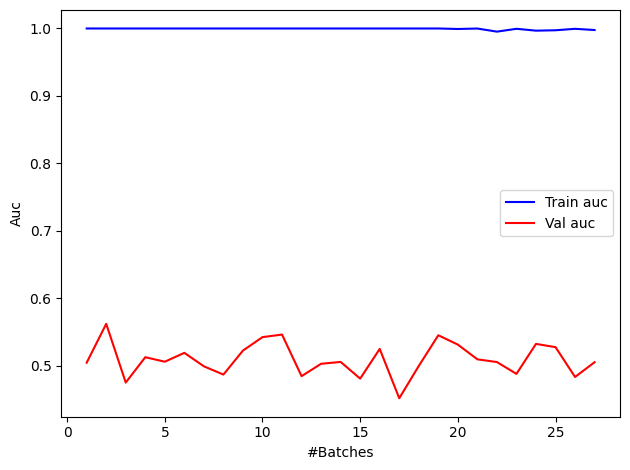

In [109]:
import os
if not os.path.exists('output'):
    os.mkdir('output')

import matplotlib.pyplot as plt

plt.plot(range(1, len(train_score)+1), train_score, color='blue', label='Train auc')
plt.plot(range(1, len(valid_score)+1), valid_score, color='red', label='Val auc')
plt.legend(loc="best")
plt.xlabel('Coefficient')
plt.ylabel('Auc')
plt.tight_layout()
plt.savefig('./output/coefficient.png', dpi=300)
plt.show()

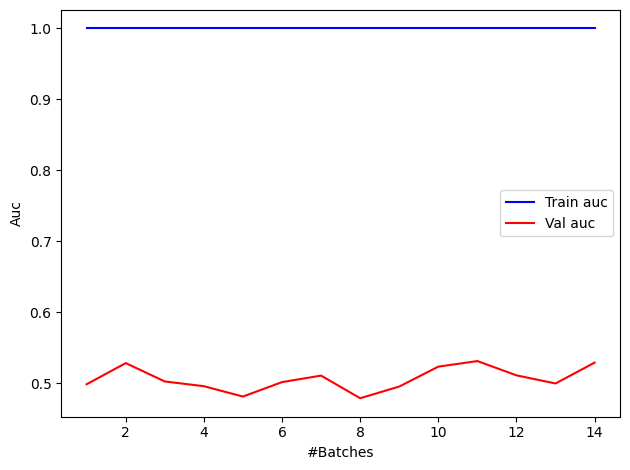

In [106]:
import os
if not os.path.exists('output'):
    os.mkdir('output')

import matplotlib.pyplot as plt

plt.plot(range(1, len(train_auc)+1), train_auc, color='blue', label='Train auc')
plt.plot(range(1, len(train_auc)+1), val_auc, color='red', label='Val auc')
plt.legend(loc="best")
plt.xlabel('#Batches')
plt.ylabel('Auc')
plt.tight_layout()
plt.show()

In [ ]:
X_valid = hashvec.transform(X_valid)
y_valid = LabelEncoder().fit_transform(y_valid)
valid_score = roc_auc_score(y_valid, model.predict_proba(hashvec.transform(X_valid))[:,1])
print(f'Valid score: {valid_score}')

In [ ]:
print(model.predict_proba(hashvec.transform(X_train[:10]))[:10,1])

In [182]:
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_auc_score

# loss='log' gives logistic regression
# sklearn version > 1.0 should use log_loss
clf = SGDClassifier(loss='log_loss', max_iter=100, tol=1e-3)
hashvec = HashingVectorizer(n_features=2**20,
                            preprocessor=feature_selection, tokenizer=tokenizer_stem_nostop)

In [187]:
batch_size = 512
classes = np.array([-1, 1])
train_auc, val_auc = [], []
# we use one batch for training and another for validation in each iteration
iters = 3

for i in range(iters):
    print(f"epoch: {i+1}/{iters}")
    train_batches = random_mini_batches(X_train, y_train, batch_size)
    valid_batches = random_mini_batches(X_valid, y_valid, int(batch_size * 0.2))
    idx = 0
    for train_batch in train_batches:
        x_batch, y_batch = train_batch
        x_batch = hashvec.transform(x_batch)
        clf.partial_fit(x_batch, y_batch, classes=classes)
        train_score = roc_auc_score(y_batch, clf.predict_proba(x_batch)[:,1])
        train_auc.append(train_score)
        print(f'[{(idx+1)*batch_size}/{X_train.shape[0]}]')
        print(f'Train score: {train_score}')
        
        x_batch, y_batch = valid_batches[idx]
        valid_score = roc_auc_score(y_batch, clf.predict_proba(hashvec.transform(x_batch))[:,1])
        val_auc.append(valid_score)
        print(f'Valid score: {valid_score}')
        idx+=1

epoch: 1/3
[512/22114]
Train score: 0.8415252808558248
Valid score: 0.501929012345679
[1024/22114]
Train score: 0.8141263940520446
Valid score: 0.4669230769230769
[1536/22114]
Train score: 0.824859619140625
Valid score: 0.48588007736943906
[2048/22114]
Train score: 0.8317387655451285
Valid score: 0.5898919753086419
[2560/22114]
Train score: 0.8276477832512315
Valid score: 0.5849129593810445
[3072/22114]
Train score: 0.8498015267175574
Valid score: 0.48286484405082786
[3584/22114]
Train score: 0.8236596576419748
Valid score: 0.6043829296424451
[4096/22114]
Train score: 0.7977598772535481
Valid score: 0.5109742010011552
[4608/22114]
Train score: 0.7850195742598484
Valid score: 0.3992263056092844
[5120/22114]
Train score: 0.7869042710767022
Valid score: 0.5191489361702128
[5632/22114]
Train score: 0.7850321395775941
Valid score: 0.5277777777777777
[6144/22114]
Train score: 0.8085817648944452
Valid score: 0.4974971120523682
[6656/22114]
Train score: 0.7578792796970399
Valid score: 0.692129

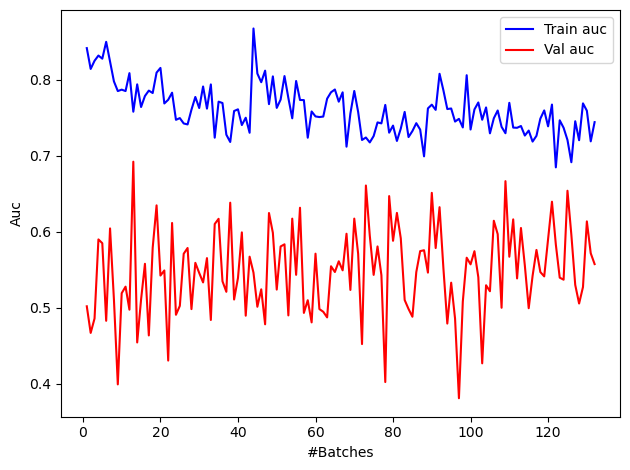

In [188]:
import os
if not os.path.exists('output'):
    os.mkdir('output')

import matplotlib.pyplot as plt

plt.plot(range(1, len(train_auc)+1), train_auc, color='blue', label='Train auc')
plt.plot(range(1, len(train_auc)+1), val_auc, color='red', label='Val auc')
plt.legend(loc="best")
plt.xlabel('#Batches')
plt.ylabel('Auc')
plt.tight_layout()
plt.show()

In [189]:
valid_score = roc_auc_score(y_valid, clf.predict_proba(hashvec.transform(X_valid))[:,1])
print(f'Valid score: {valid_score}')

Valid score: 0.5499425647451963


In [190]:
print(clf.predict_proba(hashvec.transform(X_train[:10]))[:10,1])

[0.29760802 0.49435017 0.45325655 0.42135349 0.33515924 0.5454506
 0.60607179 0.36541647 0.560992   0.67747457]


### Prediction

In [31]:
df = pd.read_csv('./datasets/test.csv')
print("Content:\n",df.loc[0])

Id = df.loc[:, 'Id'].to_numpy()
X_test = df.loc[:, 'Page content'].to_numpy()
print(X_test.shape)
print("\nId:\n", Id[0])
print("Content:\n", X_test[0])

Content:
 Id                                                          27643
Page content    <html><head><div class="article-info"><span cl...
Name: 0, dtype: object
(11847,)

Id:
 27643
Content:
 <html><head><div class="article-info"><span class="byline "><a href="/author/sam-laird/"><img alt="2016%2f09%2f15%2f63%2fhttpsd2mhye01h4nj2n.cloudfront.netmediazgkymde1lza2.9814b" class="author_image" src="http://i.amz.mshcdn.com/-qaMPB8aiQeIaoBhqlU0OLjA07A=/90x90/2016%2F09%2F15%2F63%2Fhttpsd2mhye01h4nj2n.cloudfront.netmediaZgkyMDE1LzA2.9814b.jpg"/></a><span class="author_name">By <a href="/author/sam-laird/">Sam Laird</a></span><time datetime="Mon, 09 Sep 2013 19:47:02 +0000">2013-09-09 19:47:02 UTC</time></span></div></head><body><h1 class="title">Soccer Star Gets Twitter Death Threats After Tackling One Direction Member</h1><figure class="article-image"></figure><article data-channel="entertainment"><section class="article-content"> <div class="shift-to-hero"> <p><iframe allowfullscreen="" 

### Test

In [35]:
for i in range(11847):
    print("Article ", i)
    print(feature_selection(X_test[i]))

Article  0


AttributeError: 'NoneType' object has no attribute 'text'

In [37]:
y_pred = feature_selection_part2(X_test)
print(y_pred.shape)

KeyboardInterrupt: 

### Generate Prediction

In [39]:
y_pred_word = word_model.predict_proba(tfidf.transform(X_test))[:,1]
y_pred_stats = stats_model.predict_proba(feature_selection_part2(X_test))[:,1]
propo = 0.35
y_pred = y_pred_word*propo + y_pred_stats*(1-propo)

In [40]:
output_data = {'Id': Id, 'Popularity': y_pred}
output_dataframe = pd.DataFrame(output_data)
print(output_dataframe)

output_dataframe.to_csv("./datasets/y_pred.csv", index=None)

          Id  Popularity
0      27643    0.397449
1      27644    0.567758
2      27645    0.453681
3      27646    0.464081
4      27647    0.460352
...      ...         ...
11842  39485    0.642701
11843  39486    0.522449
11844  39487    0.439964
11845  39488    0.565617
11846  39489    0.407098

[11847 rows x 2 columns]


In [ ]:
'''
          Id  Popularity
0      27643         0.4
1      27644         0.7
2      27645         0.4
3      27646         0.4
4      27647         0.5
...      ...         ...
11842  39485         0.5
11843  39486         0.5
11844  39487         0.5
11845  39488         0.6
11846  39489         0.5

[11847 rows x 2 columns]
'''